# Clustering with 2023 data ONLY

Try with only 2023 data

In [1]:
!pip install scipy==1.11.4

In [2]:
from calitp_data_analysis.sql import query_sql
from utils_transit_peer_groups import *
import sys
import altair as alt
import pandas as pd

sys.path.append("../ntd/monthly_ridership_report")
from update_vars import GCS_FILE_PATH, NTD_MODES, NTD_TOS

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [3]:
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [4]:
fixed_guideway = [
    "SR",
    "HR",
    "YR",
    "CR",
    "CC",
    "LR",
    "MG",
    "TB",
]

nonfixed_guideway = [
    "DR",
    "MB",
    "DT",
    "CB",
    "VP",
    "RB",
    "JT"
]

other_modes = [
    "FB",
    "OT", # no clue what this is, not in NTD glossary
    "OR", # same with this
    
]

mode_dict ={
    "SR":"fixed_guideway",
    "HR":"fixed_guideway",
    "YR":"fixed_guideway",
    "CR":"fixed_guideway",
    "CC":"fixed_guideway",
    "LR":"fixed_guideway",
    "MG":"fixed_guideway",
    "TB":"fixed_guideway",
    "DR":"nonfixed_guideway",
    "MB":"nonfixed_guideway",
    "DT":"nonfixed_guideway",
    "CB":"nonfixed_guideway",
    "VP":"nonfixed_guideway",
    "RB":"nonfixed_guideway",
    "JT":"nonfixed_guideway",
    "FB":"other_mode",
    "OT":"other_mode", # no clue what this is, not in NTD glossary
    "OR":"other_mode",
}

In [5]:
#ID cols
id_cols = [
    "ntd_id",
    "source_agency",
    "city",
    "primary_uza_name"
]
# include in clustering
categorical_cols = ["mode_group", "service", "reporter_type"]

# include in clustering
numerical_cols = [
    "total_upt",
    "total_vrh",
    "total_vrm",
    "opexp_total",
    "total_voms",
    # "uza_population",
    # "uza_area_sq_miles",
]

In [ ]:
# alt method to query warehous data, via cal-itp docs
# query = f"""
#         SELECT
#           upt.ntd_id,
#           upt.source_agency,
#           upt.agency_status,
#           upt.city,
#           upt.primary_uza_name,
#           upt.uza_population,
#           upt.uza_area_sq_miles,
#           upt.year,
#           upt.mode,
#           upt.service,
#           upt.reporter_type,
#           SUM(upt.upt) AS total_upt,
#           SUM(voms.voms) AS total_voms,
#           SUM(vrh.vrh) AS total_vrh,
#           SUM(vrm.vrm) AS total_vrm,
#           SUM(opexp_total.opexp_total) AS opexp_total
#         FROM
#           cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_upt AS upt
#         INNER JOIN
#           cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_voms AS voms
#         ON
#           upt.ntd_id = voms.ntd_id
#           AND upt.year = voms.year
#           AND upt.source_agency = voms.source_agency
#           AND upt.agency_status = voms.agency_status
#           AND upt.primary_uza_name = voms.primary_uza_name
#           AND upt.uza_population = voms.uza_population
#           AND upt.uza_area_sq_miles = voms.uza_area_sq_miles
#         INNER JOIN
#           cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_vrh AS vrh
#         ON
#           upt.ntd_id = vrh.ntd_id
#           AND upt.year = vrh.year
#           AND upt.source_agency = vrh.source_agency
#           AND upt.agency_status = vrh.agency_status
#           AND upt.primary_uza_name = vrh.primary_uza_name
#           AND upt.uza_population = vrh.uza_population
#           AND upt.uza_area_sq_miles = vrh.uza_area_sq_miles
#         INNER JOIN
#           cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_vrm AS vrm
#         ON
#           upt.ntd_id = vrm.ntd_id
#           AND upt.year = vrm.year
#           AND upt.source_agency = vrm.source_agency
#           AND upt.agency_status = vrm.agency_status
#           AND upt.primary_uza_name = vrm.primary_uza_name
#           AND upt.uza_population = vrm.uza_population
#           AND upt.uza_area_sq_miles = vrm.uza_area_sq_miles
#         INNER JOIN
#           cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_opexp_total AS opexp_total
#         ON
#           upt.ntd_id = opexp_total.ntd_id
#           AND upt.year = opexp_total.year
#           AND upt.source_agency = opexp_total.source_agency
#           AND upt.agency_status = opexp_total.agency_status
#           AND upt.primary_uza_name = opexp_total.primary_uza_name
#           AND upt.uza_population = opexp_total.uza_population
#           AND upt.uza_area_sq_miles = opexp_total.uza_area_sq_miles
#         WHERE
#           upt.source_state = "CA"
#           AND upt.year = 2023
#         GROUP BY
#           upt.ntd_id,
#           upt.source_agency,
#           upt.agency_status,
#           upt.city,
#           upt.year,
#           upt.primary_uza_name,
#           upt.uza_population,
#           upt.uza_area_sq_miles,
#           upt.mode,
#           upt.service,
#           upt.reporter_type
#         """

# ntd_2023_data = query_sql(query).fillna({
#     "city":"none",
#     "total_upt":0,
#     "total_vrh":0,
#     "total_vrm":0,
#     "opexp_total":0,
#     "total_voms":0,
# })

#### Save query data to GCS

In [7]:
gcs_file_path = "gs://calitp-analytics-data/data-analyses/transit_peer_groups/"
# ntd_2023_data.to_parquet(f"{gcs_file_path}ntd_2023_data.parquet")

#### read in saved query data from GCS

In [8]:
ntd_2023_data = pd.read_parquet(f"{gcs_file_path}ntd_2023_data.parquet")

In [9]:
ntd_2023_data[numerical_cols] = ntd_2023_data[numerical_cols].astype("int64", errors="ignore")

## replace values for mode and tos

In [10]:
service_dict = {
    "TX":"PT",
    "TN":"PT"
}

ntd_2023_data["service"] = ntd_2023_data["service"].replace(service_dict)

In [11]:
ntd_2023_data["service"].unique()

array(['PT', 'DO'], dtype=object)

In [12]:
ntd_2023_data["mode_group"] = ntd_2023_data["mode"].map(mode_dict)

In [13]:
ntd_2023_data["mode_group"].unique()

array(['nonfixed_guideway', 'fixed_guideway', 'other_mode'], dtype=object)

## 2023 - explore data

In [14]:
display(
    ntd_2023_data.info(),

    ntd_2023_data["service"].value_counts(),

    ntd_2023_data["mode_group"].value_counts(),
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ntd_id             667 non-null    object 
 1   source_agency      667 non-null    object 
 2   agency_status      667 non-null    object 
 3   city               667 non-null    object 
 4   primary_uza_name   667 non-null    object 
 5   uza_population     667 non-null    int64  
 6   uza_area_sq_miles  667 non-null    float64
 7   year               667 non-null    int64  
 8   mode               667 non-null    object 
 9   service            667 non-null    object 
 10  reporter_type      667 non-null    object 
 11  total_upt          667 non-null    int64  
 12  total_voms         667 non-null    int64  
 13  total_vrh          667 non-null    int64  
 14  total_vrm          667 non-null    int64  
 15  opexp_total        667 non-null    int64  
 16  mode_group         667 non

None

PT    437
DO    230
Name: service, dtype: int64

nonfixed_guideway    623
fixed_guideway        28
other_mode            16
Name: mode_group, dtype: int64

## 2023 - correlation matrix

In [15]:
ntd_2023_data[numerical_cols].corr()

,total_upt,total_vrh,total_vrm,opexp_total,total_voms
total_upt,1.000000,0.447327,0.438990,0.467137,0.428977
total_vrh,0.447327,1.000000,0.993603,0.970093,0.992880
total_vrm,0.438990,0.993603,1.000000,0.958037,0.991704
opexp_total,0.467137,0.970093,0.958037,1.000000,0.939107
total_voms,0.428977,0.992880,0.991704,0.939107,1.000000


## 2023 - Manual Hierarchal clustering w/ ward

In [ ]:
from sklearn.cluster import AgglomerativeClustering 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
numerical_cols

In [ ]:
categorical_cols

In [ ]:
# 1. set up pre-processing steps with column transformer

preprocessor = ColumnTransformer(
    [
        ("ntd_metrics", StandardScaler(), numerical_cols),
        ("categorical", OneHotEncoder(drop="first", sparse_output=False), categorical_cols)
    ]
)
preprocessor

In [ ]:
# 2. set up pipeline. First pre-processing, then clustering
pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("clustering", AgglomerativeClustering(n_clusters=10, linkage="ward"))
    ]
)

pipeline

### Clustering with entire raw data 

In [ ]:
# 3. use pipeline to fit clustering model. create new column for clustering
ntd_2023_fit = ntd_2023_data.copy() # why do i need to copy/clone?

ntd_2023_fit["cluster_name"] = pipeline.fit_predict(ntd_2023_fit)

In [ ]:
display(
    ntd_2023_fit["cluster_name"].value_counts(),
    ntd_2023_fit[["source_agency","total_upt","total_vrh","cluster_name"]].sample(3)
)

In [ ]:
ntd_2023_data["service"].unique()

### what are the feature columns with onehotencoding drop=first?

In [ ]:
feature_names = preprocessor.get_feature_names_out()
display(list(feature_names))

### what are the feature columns with `onehotencoding drop=None`?


In [ ]:
preprocessor_2 = ColumnTransformer(
    [
        ("ntd_metrics", StandardScaler(), numerical_cols),
        ("categorical", OneHotEncoder(
            # drop="first", 
            sparse_output=False
        ), categorical_cols)
    ]
)

pipeline_2 = Pipeline(
    [
        ("preprocessing", preprocessor_2),
        ("clustering", AgglomerativeClustering(n_clusters=10, linkage="ward"))
    ]
)

ntd_2023_fit_2 = ntd_2023_data.copy()

ntd_2023_fit_2["cluster"] = pipeline_2.fit_predict(ntd_2023_fit_2)

In [ ]:
feature_names_2= preprocessor_2.get_feature_names_out()

display(list(feature_names_2)) # service_DO appears

## Using utils function to cluster

### Group Datset by `mode_group`

In [16]:
ntd_2023_grouped = ntd_2023_data.groupby(id_cols+["mode_group"]).agg({
    num_col:"sum" for num_col in numerical_cols
}).reset_index()


### grouped 2023 data, all modes

In [28]:
cluster_2023 = make_hierarchal_clustering(
    data = ntd_2023_grouped,
    num_cols = numerical_cols,
    cat_cols = ["mode_group"],
    cluster_num = 10
)

z_cluster_2023 = make_dendrogram_data(
    data = cluster_2023,
    num_cols = numerical_cols,
    cat_cols = ["mode_group"]
)

display(cluster_2023["cluster_name"].value_counts())

plt.figure(figsize=(20, 10))
dendrogram(
    z_cluster_2023, 
    labels=cluster_2023["source_agency"].tolist(), 
    leaf_rotation=90
)
plt.title("Dendrogram (Ward's Method)")
plt.xlabel("ntd_id")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

for i in cluster_2023["cluster_name"].unique():
    print(f"""
    \n How many unique agencies are in Cluster {i}: {cluster_2023[cluster_2023['cluster_name']==i]["source_agency"].nunique()}
    Cluster {i} sample:""")
    display(cluster_2023[cluster_2023["cluster_name"]==i].head()),
    print(f"\nCluster {i} summary stats:")
    display(cluster_2023[cluster_2023["cluster_name"]==i].describe())

### 2023 data, non-fixed route modes

In [36]:
nonfixed_guideway = ntd_2023_grouped[ntd_2023_grouped["mode_group"]=="nonfixed_guideway"]

4    226
6     12
0      3
2      2
1      2
7      1
5      1
9      1
8      1
3      1
Name: cluster_name, dtype: int64

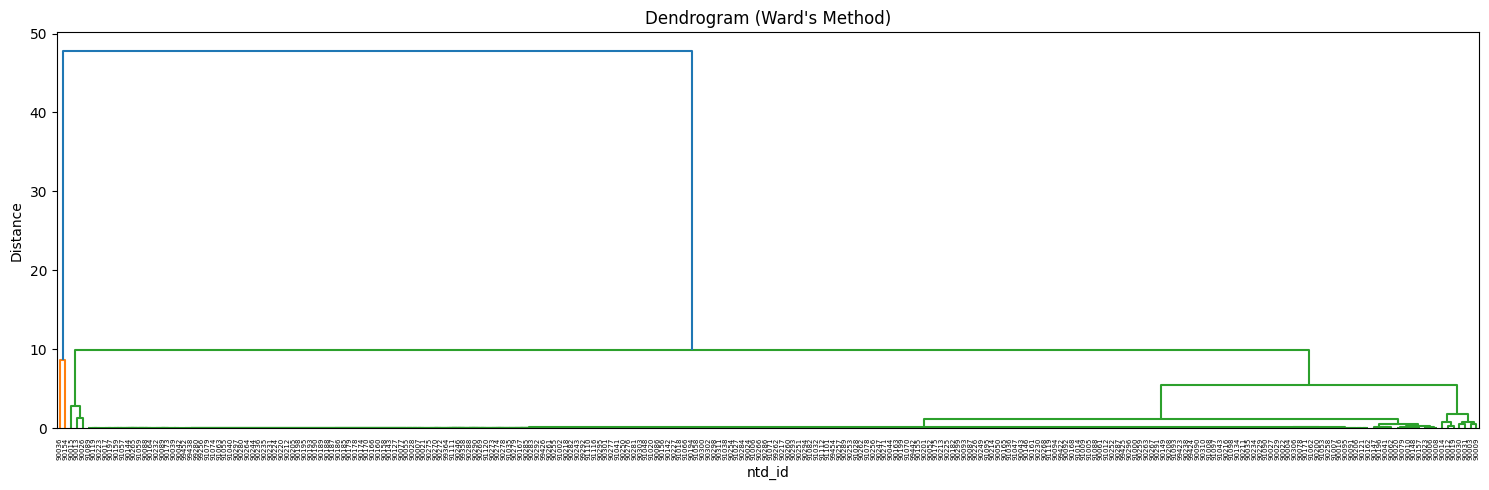


    
 How many unique agencies are in Cluster 2: 2
    Cluster 2 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
1,90003,San Francisco Bay Area Rapid Transit District ...,Oakland,"San Francisco--Oakland, CA",nonfixed_guideway,0,681018500,21308437250,195646239500,145500,2
6,90009,San Mateo County Transit District (SMCTD),San Carlos,"San Francisco--Oakland, CA",nonfixed_guideway,11370903120,844783344,10100632608,249542380368,428976,2



Cluster 2 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000,2.0
mean,5.685452e+09,7.629009e+08,1.570453e+10,2.225943e+11,287238.000000,2.0
std,8.040443e+09,1.157992e+08,7.925115e+09,3.811033e+10,200447.801904,0.0
min,0.000000e+00,6.810185e+08,1.010063e+10,1.956462e+11,145500.000000,2.0
25%,2.842726e+09,7.219597e+08,1.290258e+10,2.091203e+11,216369.000000,2.0
50%,5.685452e+09,7.629009e+08,1.570453e+10,2.225943e+11,287238.000000,2.0
75%,8.528177e+09,8.038421e+08,1.850649e+10,2.360683e+11,358107.000000,2.0
max,1.137090e+10,8.447833e+08,2.130844e+10,2.495424e+11,428976.000000,2.0



    
 How many unique agencies are in Cluster 4: 226
    Cluster 4 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
2,90004,Golden Empire Transit District (GET),Bakersfield,"Bakersfield, CA",nonfixed_guideway,266781033,23436378,317845296,2960905266,7209,4
4,90007,City of Modesto (MAX),none,"Modesto, CA",nonfixed_guideway,0,0,0,0,0,4
14,90016,"Golden Gate Bridge, Highway and Transportation...",San Francisco,"San Francisco--Oakland, CA",nonfixed_guideway,338146048,27674880,460013760,22968043392,11904,4
16,90017,City of Santa Rosa - Transit Division,Santa Rosa,"Santa Rosa, CA",nonfixed_guideway,106899426,6831216,76119102,1105818399,2349,4
21,90021,Los Angeles County Metropolitan Transportation...,none,"Los Angeles--Long Beach--Anaheim, CA",nonfixed_guideway,0,0,0,0,0,4



Cluster 4 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,2.260000e+02,2.260000e+02,2.260000e+02,2.260000e+02,226.000000,226.0
mean,3.015625e+07,3.563901e+06,5.674015e+07,5.766812e+08,1765.287611,4.0
std,8.758801e+07,1.022764e+07,1.672354e+08,2.044182e+09,4619.415844,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,4.0
25%,6.992250e+03,3.336750e+03,3.238000e+04,4.309695e+05,3.000000,4.0
50%,7.432300e+05,2.001920e+05,2.256872e+06,1.904360e+07,128.000000,4.0
75%,9.644576e+06,1.626178e+06,2.090256e+07,2.290462e+08,969.000000,4.0
max,6.742484e+08,8.570312e+07,1.373459e+09,2.296804e+10,33453.000000,4.0



    
 How many unique agencies are in Cluster 6: 12
    Cluster 6 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
3,90006,Santa Cruz Metropolitan Transit District (SCMTD),Santa Cruz,"Santa Cruz, CA",nonfixed_guideway,4341633696,278313408,3855763296,62945840016,120528,6
5,90008,City of Santa Monica (BBB) - Department of Tra...,Santa Monica,"Los Angeles--Long Beach--Anaheim, CA",nonfixed_guideway,4854828125,260590000,2450246875,50485795000,89375,6
7,90010,City of Torrance (TTS) - Transit Department,Torrance,"Los Angeles--Long Beach--Anaheim, CA",nonfixed_guideway,2384742384,134169696,1818096192,33137987760,95904,6
19,90020,Santa Barbara Metropolitan Transit District (S...,Santa Barbara,"Santa Barbara, CA",nonfixed_guideway,2834047500,105446250,1278271875,16932812500,39375,6
23,90023,Long Beach Transit (LBT),Long Beach,"Los Angeles--Long Beach--Anaheim, CA",nonfixed_guideway,10501878125,328398500,3246311500,56129280000,83500,6



Cluster 6 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,12.000000,12.0
mean,4.133634e+09,2.673126e+08,3.681424e+09,4.494376e+10,122254.250000,6.0
std,3.291951e+09,1.437038e+08,2.011490e+09,2.282101e+10,68759.037519,0.0
min,2.871753e+08,8.403635e+07,1.278272e+09,9.316946e+09,39375.000000,6.0
25%,2.208796e+09,1.478129e+08,2.418169e+09,2.484077e+10,73618.000000,6.0
50%,3.129097e+09,2.694517e+08,2.917916e+09,5.330754e+10,92639.500000,6.0
75%,5.250561e+09,3.544161e+08,4.615413e+09,6.312150e+10,195405.250000,6.0
max,1.050188e+10,5.227350e+08,7.867703e+09,7.259978e+10,231250.000000,6.0



    
 How many unique agencies are in Cluster 0: 3
    Cluster 0 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
8,90012,San Joaquin Regional Transit District (RTD),Stockton,"Stockton, CA",nonfixed_guideway,23017890000,1976640000,26122860000,423491840000,930000,0
11,90014,Alameda-Contra Costa Transit District,Oakland,"San Francisco--Oakland, CA",nonfixed_guideway,45606313872,2653795872,28966434624,689999057280,803520,0
18,90019,Sacramento Regional Transit District,Sacramento,"Sacramento, CA",nonfixed_guideway,19709203948,2097958128,28880955348,490542980466,769692,0



Cluster 0 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000,3.0
mean,2.944447e+10,2.242798e+09,2.799008e+10,5.346780e+11,834404.000000,0.0
std,1.409400e+10,3.610664e+08,1.617628e+09,1.386270e+11,84498.697079,0.0
min,1.970920e+10,1.976640e+09,2.612286e+10,4.234918e+11,769692.000000,0.0
25%,2.136355e+10,2.037299e+09,2.750191e+10,4.570174e+11,786606.000000,0.0
50%,2.301789e+10,2.097958e+09,2.888096e+10,4.905430e+11,803520.000000,0.0
75%,3.431210e+10,2.375877e+09,2.892369e+10,5.902710e+11,866760.000000,0.0
max,4.560631e+10,2.653796e+09,2.896643e+10,6.899991e+11,930000.000000,0.0



    
 How many unique agencies are in Cluster 7: 1
    Cluster 7 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
10,90013,Santa Clara Valley Transportation Authority (VTA),San Jose,"San Jose, CA",nonfixed_guideway,80716316672,5324295168,66905994240,1394906022912,1572864,7



Cluster 7 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.0
mean,8.071632e+10,5.324295e+09,6.690599e+10,1.394906e+12,1572864.0,7.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,8.071632e+10,5.324295e+09,6.690599e+10,1.394906e+12,1572864.0,7.0
25%,8.071632e+10,5.324295e+09,6.690599e+10,1.394906e+12,1572864.0,7.0
50%,8.071632e+10,5.324295e+09,6.690599e+10,1.394906e+12,1572864.0,7.0
75%,8.071632e+10,5.324295e+09,6.690599e+10,1.394906e+12,1572864.0,7.0
max,8.071632e+10,5.324295e+09,6.690599e+10,1.394906e+12,1572864.0,7.0



    
 How many unique agencies are in Cluster 5: 1
    Cluster 5 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
13,90015,City and County of San Francisco (SFMTA) - Tra...,San Francisco,"San Francisco--Oakland, CA",nonfixed_guideway,173086298854,3397994670,24907847433,1002754932081,796446,5



Cluster 5 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.0
mean,1.730863e+11,3.397995e+09,2.490785e+10,1.002755e+12,796446.0,5.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,1.730863e+11,3.397995e+09,2.490785e+10,1.002755e+12,796446.0,5.0
25%,1.730863e+11,3.397995e+09,2.490785e+10,1.002755e+12,796446.0,5.0
50%,1.730863e+11,3.397995e+09,2.490785e+10,1.002755e+12,796446.0,5.0
75%,1.730863e+11,3.397995e+09,2.490785e+10,1.002755e+12,796446.0,5.0
max,1.730863e+11,3.397995e+09,2.490785e+10,1.002755e+12,796446.0,5.0



    
 How many unique agencies are in Cluster 9: 1
    Cluster 9 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
27,90026,San Diego Metropolitan Transit System (MTS),San Diego,"San Diego, CA",nonfixed_guideway,77946071203,5295664122,70169463042,726918729684,1592892,9



Cluster 9 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.0
mean,7.794607e+10,5.295664e+09,7.016946e+10,7.269187e+11,1592892.0,9.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,7.794607e+10,5.295664e+09,7.016946e+10,7.269187e+11,1592892.0,9.0
25%,7.794607e+10,5.295664e+09,7.016946e+10,7.269187e+11,1592892.0,9.0
50%,7.794607e+10,5.295664e+09,7.016946e+10,7.269187e+11,1592892.0,9.0
75%,7.794607e+10,5.295664e+09,7.016946e+10,7.269187e+11,1592892.0,9.0
max,7.794607e+10,5.295664e+09,7.016946e+10,7.269187e+11,1592892.0,9.0



    
 How many unique agencies are in Cluster 1: 2
    Cluster 1 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
33,90030,North County Transit District (NCTD),Oceanside,"San Diego, CA",nonfixed_guideway,30407781186,1533483576,23923196424,395725656492,551124,1
34,90031,Riverside Transit Agency (RTA),Riverside,"Riverside--San Bernardino, CA",nonfixed_guideway,12596743257,1486795240,22182774173,218920409246,506611,1



Cluster 1 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000,2.0
mean,2.150226e+10,1.510139e+09,2.305299e+10,3.073230e+11,528867.500000,1.0
std,1.259431e+10,3.301364e+07,1.230664e+09,1.250202e+11,31475.444151,0.0
min,1.259674e+10,1.486795e+09,2.218277e+10,2.189204e+11,506611.000000,1.0
25%,1.704950e+10,1.498467e+09,2.261788e+10,2.631217e+11,517739.250000,1.0
50%,2.150226e+10,1.510139e+09,2.305299e+10,3.073230e+11,528867.500000,1.0
75%,2.595502e+10,1.521811e+09,2.348809e+10,3.515243e+11,539995.750000,1.0
max,3.040778e+10,1.533484e+09,2.392320e+10,3.957257e+11,551124.000000,1.0



    
 How many unique agencies are in Cluster 8: 1
    Cluster 8 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
37,90036,Orange County Transportation Authority (OCTA),Orange,"Los Angeles--Long Beach--Anaheim, CA",nonfixed_guideway,478390107008,24879221037,335795843097,3860309607264,9679032,8



Cluster 8 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.0
mean,4.783901e+11,2.487922e+10,3.357958e+11,3.860310e+12,9679032.0,8.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,4.783901e+11,2.487922e+10,3.357958e+11,3.860310e+12,9679032.0,8.0
25%,4.783901e+11,2.487922e+10,3.357958e+11,3.860310e+12,9679032.0,8.0
50%,4.783901e+11,2.487922e+10,3.357958e+11,3.860310e+12,9679032.0,8.0
75%,4.783901e+11,2.487922e+10,3.357958e+11,3.860310e+12,9679032.0,8.0
max,4.783901e+11,2.487922e+10,3.357958e+11,3.860310e+12,9679032.0,8.0



    
 How many unique agencies are in Cluster 3: 1
    Cluster 3 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
77,90154,Los Angeles County Metropolitan Transportation...,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",nonfixed_guideway,871872614400,25252331520,336284070912,6748030116864,8143872,3



Cluster 3 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.0
mean,8.718726e+11,2.525233e+10,3.362841e+11,6.748030e+12,8143872.0,3.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,8.718726e+11,2.525233e+10,3.362841e+11,6.748030e+12,8143872.0,3.0
25%,8.718726e+11,2.525233e+10,3.362841e+11,6.748030e+12,8143872.0,3.0
50%,8.718726e+11,2.525233e+10,3.362841e+11,6.748030e+12,8143872.0,3.0
75%,8.718726e+11,2.525233e+10,3.362841e+11,6.748030e+12,8143872.0,3.0
max,8.718726e+11,2.525233e+10,3.362841e+11,6.748030e+12,8143872.0,3.0


In [45]:
non_fixed_route_cluster = make_hierarchal_clustering(
    data = nonfixed_guideway,
    num_cols = numerical_cols,
    cat_cols = ["mode_group"],
    cluster_num = 10
    
)

z_nonfixed_route = make_dendrogram_data(
    data = nonfixed_guideway,
    num_cols = numerical_cols,
    cat_cols = ["mode_group"]
)

display(non_fixed_route_cluster["cluster_name"].value_counts())


plt.figure(figsize=(15, 5))
dendrogram(z_nonfixed_route, labels=nonfixed_guideway["ntd_id"].tolist(), leaf_rotation=90)
plt.title("Dendrogram (Ward's Method)")
plt.xlabel("ntd_id")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


for i in non_fixed_route_cluster["cluster_name"].unique():
    print(f"""
    \n How many unique agencies are in Cluster {i}: {non_fixed_route_cluster[non_fixed_route_cluster['cluster_name']==i]["source_agency"].nunique()}
    Cluster {i} sample:""")
    display(non_fixed_route_cluster[non_fixed_route_cluster["cluster_name"]==i].head()),
    print(f"\nCluster {i} summary stats:")
    display(non_fixed_route_cluster[non_fixed_route_cluster["cluster_name"]==i].describe())

    
# fig_nonfixed_route = ff.create_dendrogram(z_nonfixed_route, labels = non_fixed_route_data["source_agency"].tolist())
# fig_nonfixed_route.update_layout(width=800, height=500)
# fig_nonfixed_route.show()

### 2023 data, fixed route modes

In [47]:
fixed_route_data = ntd_2023_grouped[ntd_2023_grouped["mode_group"]=="fixed_guideway"]

,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
0,90003,San Francisco Bay Area Rapid Transit District ...,Oakland,"San Francisco--Oakland, CA",fixed_guideway,31727751250,1021527750,31962655875,293469359250,218250,6
9,90013,Santa Clara Valley Transportation Authority (VTA),San Jose,"San Jose, CA",fixed_guideway,16989417472,1774765056,22301998080,464968674304,524288,8
12,90015,City and County of San Francisco (SFMTA) - Tra...,San Francisco,"San Francisco--Oakland, CA",fixed_guideway,160959292039,4530659560,33210463244,1337006576108,1061928,7
17,90019,Sacramento Regional Transit District,Sacramento,"Sacramento, CA",fixed_guideway,14744348920,349659688,4813492558,81757163411,128282,3
20,90021,Los Angeles County Metropolitan Transportation...,none,"Los Angeles--Long Beach--Anaheim, CA",fixed_guideway,0,0,0,0,0,0


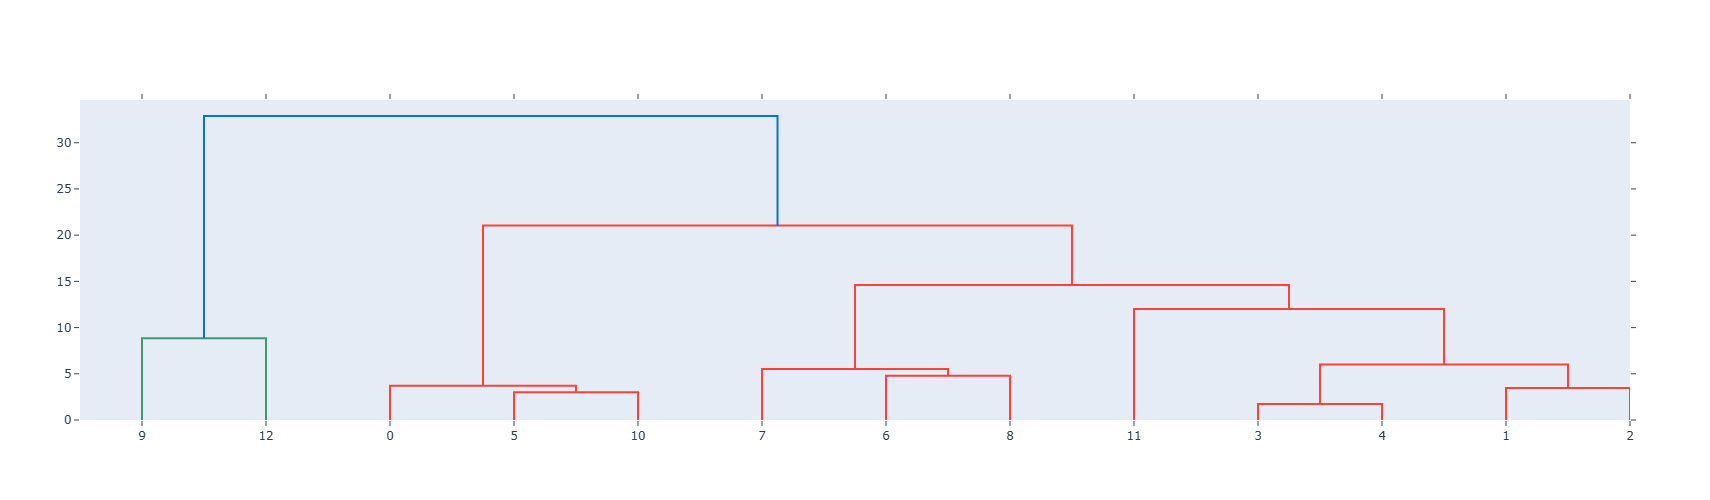

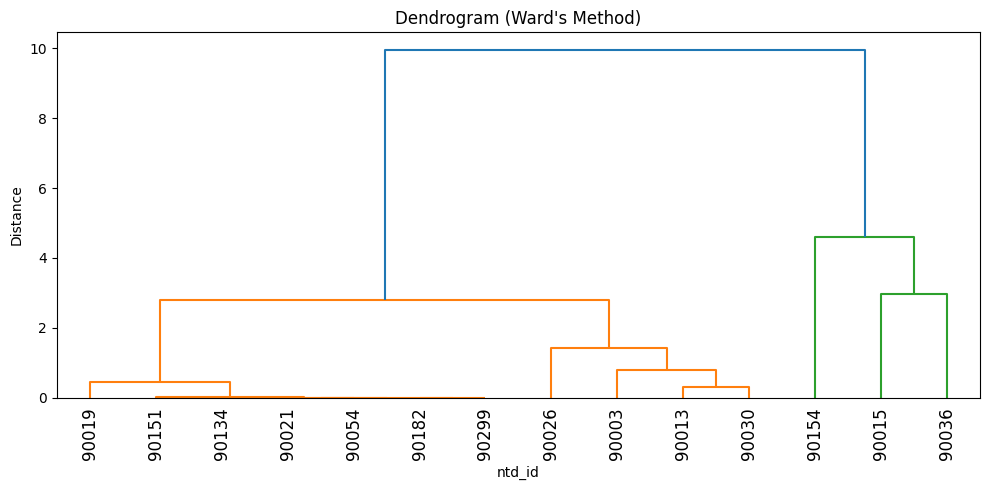


    
 How many unique agencies are in Cluster 6: 1
    Cluster 6 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
0,90003,San Francisco Bay Area Rapid Transit District ...,Oakland,"San Francisco--Oakland, CA",fixed_guideway,31727751250,1021527750,31962655875,293469359250,218250,6



    
 How many unique agencies are in Cluster 8: 1
    Cluster 8 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
9,90013,Santa Clara Valley Transportation Authority (VTA),San Jose,"San Jose, CA",fixed_guideway,16989417472,1774765056,22301998080,464968674304,524288,8



    
 How many unique agencies are in Cluster 7: 1
    Cluster 7 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
12,90015,City and County of San Francisco (SFMTA) - Tra...,San Francisco,"San Francisco--Oakland, CA",fixed_guideway,160959292039,4530659560,33210463244,1337006576108,1061928,7



    
 How many unique agencies are in Cluster 3: 1
    Cluster 3 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
17,90019,Sacramento Regional Transit District,Sacramento,"Sacramento, CA",fixed_guideway,14744348920,349659688,4813492558,81757163411,128282,3



    
 How many unique agencies are in Cluster 0: 5
    Cluster 0 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
20,90021,Los Angeles County Metropolitan Transportation...,none,"Los Angeles--Long Beach--Anaheim, CA",fixed_guideway,0,0,0,0,0,0
45,90054,"San Diego Trolley, Inc. (MTS)",none,"San Diego, CA",fixed_guideway,0,0,0,0,0,0
65,90134,Peninsula Corridor Joint Powers Board (PCJPB),San Carlos,"San Francisco--Oakland, CA",fixed_guideway,112193856,1713224,54405024,1383146680,680,0
99,90182,Altamont Corridor Express (ACE),Stockton,"Stockton, CA",fixed_guideway,7591968,198656,7908240,289204088,216,0
196,90299,Sonoma-Marin Area Rail Transit District (SMART),Petaluma,"Santa Rosa, CA",fixed_guideway,10241584,273784,7818472,244680528,96,0



    
 How many unique agencies are in Cluster 5: 1
    Cluster 5 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
26,90026,San Diego Metropolitan Transit System (MTS),San Diego,"San Diego, CA",fixed_guideway,86549711360,882610687,11694910507,121153121614,265482,5



    
 How many unique agencies are in Cluster 9: 1
    Cluster 9 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
32,90030,North County Transit District (NCTD),Oceanside,"San Diego, CA",fixed_guideway,16388019873,1916854470,29903995530,494657070615,688905,9



    
 How many unique agencies are in Cluster 4: 1
    Cluster 4 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
36,90036,Orange County Transportation Authority (OCTA),Orange,"Los Angeles--Long Beach--Anaheim, CA",fixed_guideway,0,5528715786,74621298466,857846579392,2150896,4



    
 How many unique agencies are in Cluster 1: 1
    Cluster 1 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
75,90151,Southern California Regional Rail Authority (S...,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",fixed_guideway,59254464,4902224,177320976,4453328064,3120,1



    
 How many unique agencies are in Cluster 2: 1
    Cluster 2 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
76,90154,Los Angeles County Metropolitan Transportation...,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",fixed_guideway,259862208512,8417443840,112094690304,2249343372288,2714624,2


In [49]:
fixed_route_2023 = make_hierarchal_clustering(
    data = fixed_route_data,
    num_cols = numerical_cols,
    cat_cols = ["mode_group"],
    cluster_num = 10
    
)

z_fixed_route = make_dendrogram_data(
    data = fixed_route_data,
    num_cols = numerical_cols,
    cat_cols = ["mode_group"]
)

display(fixed_route_2023.head())


fig_fixed_route = ff.create_dendrogram(z_fixed_route,)
fig_fixed_route.update_layout(width=800, height=500)
fig_fixed_route.show()


plt.figure(figsize=(10, 5))
dendrogram(z_fixed_route, labels=fixed_route_data["ntd_id"].tolist(), leaf_rotation=90)
plt.title("Dendrogram (Ward's Method)")
plt.xlabel("ntd_id")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


for i in fixed_route_2023["cluster_name"].unique():
    print(f"""
    \n How many unique agencies are in Cluster {i}: {fixed_route_2023[fixed_route_2023['cluster_name']==i]["source_agency"].nunique()}
    Cluster {i} sample:""")
    display(fixed_route_2023[fixed_route_2023["cluster_name"]==i].head())

### 2023 data, other modes, PT/DO service

In [55]:
other_mode_2023 = ntd_2023_grouped[ntd_2023_grouped["mode_group"]=="other_mode"]

0    6
5    1
7    1
8    1
9    1
6    1
4    1
3    1
1    1
2    1
Name: cluster_name, dtype: int64

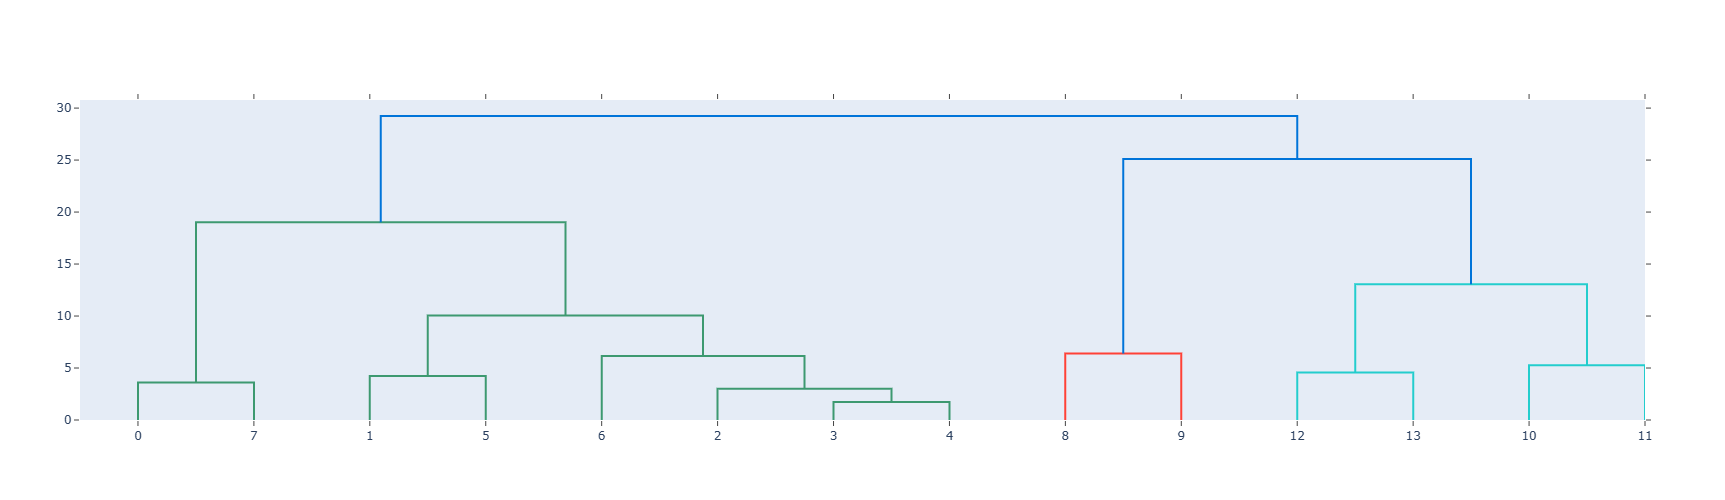


    
 How many unique agencies are in Cluster 5: 1
    Cluster 5 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
15,90016,"Golden Gate Bridge, Highway and Transportation...",San Francisco,"San Francisco--Oakland, CA",other_mode,295854592,9224960,153337920,7656014464,3968,5



Cluster 5 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.0,1.0,1.0,1.000000e+00,1.0,1.0
mean,295854592.0,9224960.0,153337920.0,7.656014e+09,3968.0,5.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,295854592.0,9224960.0,153337920.0,7.656014e+09,3968.0,5.0
25%,295854592.0,9224960.0,153337920.0,7.656014e+09,3968.0,5.0
50%,295854592.0,9224960.0,153337920.0,7.656014e+09,3968.0,5.0
75%,295854592.0,9224960.0,153337920.0,7.656014e+09,3968.0,5.0
max,295854592.0,9224960.0,153337920.0,7.656014e+09,3968.0,5.0



    
 How many unique agencies are in Cluster 7: 1
    Cluster 7 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
24,90023,Long Beach Transit (LBT),Long Beach,"Los Angeles--Long Beach--Anaheim, CA",other_mode,0,82099625,811577875,14032320000,20875,7



Cluster 7 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.0,1.0,1.0,1.000000e+00,1.0,1.0
mean,0.0,82099625.0,811577875.0,1.403232e+10,20875.0,7.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,82099625.0,811577875.0,1.403232e+10,20875.0,7.0
25%,0.0,82099625.0,811577875.0,1.403232e+10,20875.0,7.0
50%,0.0,82099625.0,811577875.0,1.403232e+10,20875.0,7.0
75%,0.0,82099625.0,811577875.0,1.403232e+10,20875.0,7.0
max,0.0,82099625.0,811577875.0,1.403232e+10,20875.0,7.0



    
 How many unique agencies are in Cluster 0: 6
    Cluster 0 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
30,90028,City of Vallejo Transportation Program (Vallej...,none,"Vallejo, CA",other_mode,0,0,0,0,0,0
74,90150,City of Alameda Ferry Services,none,"San Francisco--Oakland, CA",other_mode,0,0,0,0,0,0
225,91040,City of Dinuba,none,California Non-UZA,other_mode,0,0,0,0,0,0
262,99256,Susanville Indian Rancheria(SIR),none,California Non-UZA,other_mode,0,0,0,0,0,0
264,99262,Yurok Tribe - Transportation Department,Klamath,California Non-UZA,other_mode,0,62100,814725,8607357,81,0



Cluster 0 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,6.000000,6.000000,6.000000,6.000000e+00,6.000000,6.0
mean,33333.333333,11433.333333,142454.166667,1.601260e+06,13.833333,0.0
std,81649.658093,24957.296862,329732.524335,3.455512e+06,32.914536,0.0
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0
75%,0.000000,4875.000000,30000.000000,7.501500e+05,1.500000,0.0
max,200000.000000,62100.000000,814725.000000,8.607357e+06,81.000000,0.0



    
 How many unique agencies are in Cluster 8: 1
    Cluster 8 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
112,90197,City of Tracy - Transit Division,Tracy,"Tracy--Mountain House, CA",other_mode,0,2230528,23780096,356156864,832,8



Cluster 8 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.0,1.0,1.0,1.0,1.0,1.0
mean,0.0,2230528.0,23780096.0,356156864.0,832.0,8.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,2230528.0,23780096.0,356156864.0,832.0,8.0
25%,0.0,2230528.0,23780096.0,356156864.0,832.0,8.0
50%,0.0,2230528.0,23780096.0,356156864.0,832.0,8.0
75%,0.0,2230528.0,23780096.0,356156864.0,832.0,8.0
max,0.0,2230528.0,23780096.0,356156864.0,832.0,8.0



    
 How many unique agencies are in Cluster 9: 1
    Cluster 9 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
131,90225,San Francisco Bay Area Water Emergency Transpo...,San Francisco,"San Francisco--Oakland, CA",other_mode,32394336,198880,4121480,442400136,88,9



Cluster 9 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.0,1.0,1.0,1.0,1.0,1.0
mean,32394336.0,198880.0,4121480.0,442400136.0,88.0,9.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,32394336.0,198880.0,4121480.0,442400136.0,88.0,9.0
25%,32394336.0,198880.0,4121480.0,442400136.0,88.0,9.0
50%,32394336.0,198880.0,4121480.0,442400136.0,88.0,9.0
75%,32394336.0,198880.0,4121480.0,442400136.0,88.0,9.0
max,32394336.0,198880.0,4121480.0,442400136.0,88.0,9.0



    
 How many unique agencies are in Cluster 6: 1
    Cluster 6 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
212,91009,San Benito County Local Transportation Authori...,Hollister,California Non-UZA,other_mode,0,1540800,24304384,139715072,576,6



Cluster 6 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.0,1.0,1.0,1.0,1.0,1.0
mean,0.0,1540800.0,24304384.0,139715072.0,576.0,6.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,1540800.0,24304384.0,139715072.0,576.0,6.0
25%,0.0,1540800.0,24304384.0,139715072.0,576.0,6.0
50%,0.0,1540800.0,24304384.0,139715072.0,576.0,6.0
75%,0.0,1540800.0,24304384.0,139715072.0,576.0,6.0
max,0.0,1540800.0,24304384.0,139715072.0,576.0,6.0



    
 How many unique agencies are in Cluster 4: 1
    Cluster 4 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
215,91014,City of Rio Vista - Department of Public Works,Rio Vista,California Non-UZA,other_mode,0,764208,9670104,124820352,432,4



Cluster 4 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.0,1.0,1.0,1.0,1.0,1.0
mean,0.0,764208.0,9670104.0,124820352.0,432.0,4.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,764208.0,9670104.0,124820352.0,432.0,4.0
25%,0.0,764208.0,9670104.0,124820352.0,432.0,4.0
50%,0.0,764208.0,9670104.0,124820352.0,432.0,4.0
75%,0.0,764208.0,9670104.0,124820352.0,432.0,4.0
max,0.0,764208.0,9670104.0,124820352.0,432.0,4.0



    
 How many unique agencies are in Cluster 3: 1
    Cluster 3 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
245,91088,County of Glenn - Glenn County Planning and Co...,Willows,California Non-UZA,other_mode,0,725000,16158500,121001250,500,3



Cluster 3 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.0,1.0,1.0,1.0,1.0,1.0
mean,0.0,725000.0,16158500.0,121001250.0,500.0,3.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,725000.0,16158500.0,121001250.0,500.0,3.0
25%,0.0,725000.0,16158500.0,121001250.0,500.0,3.0
50%,0.0,725000.0,16158500.0,121001250.0,500.0,3.0
75%,0.0,725000.0,16158500.0,121001250.0,500.0,3.0
max,0.0,725000.0,16158500.0,121001250.0,500.0,3.0



    
 How many unique agencies are in Cluster 1: 1
    Cluster 1 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
247,91089,Tehama County (TRAX),Gerber,California Non-UZA,other_mode,0,6866000,157595750,525380250,3500,1



Cluster 1 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.0,1.0,1.0,1.0,1.0,1.0
mean,0.0,6866000.0,157595750.0,525380250.0,3500.0,1.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,6866000.0,157595750.0,525380250.0,3500.0,1.0
25%,0.0,6866000.0,157595750.0,525380250.0,3500.0,1.0
50%,0.0,6866000.0,157595750.0,525380250.0,3500.0,1.0
75%,0.0,6866000.0,157595750.0,525380250.0,3500.0,1.0
max,0.0,6866000.0,157595750.0,525380250.0,3500.0,1.0



    
 How many unique agencies are in Cluster 2: 1
    Cluster 2 sample:


,ntd_id,source_agency,city,primary_uza_name,mode_group,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
253,91098,Lassen Transit Service Agency (LTSA),Susanville,California Non-UZA,other_mode,0,542080,13096064,83503936,320,2



Cluster 2 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.0,1.0,1.0,1.0,1.0,1.0
mean,0.0,542080.0,13096064.0,83503936.0,320.0,2.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,542080.0,13096064.0,83503936.0,320.0,2.0
25%,0.0,542080.0,13096064.0,83503936.0,320.0,2.0
50%,0.0,542080.0,13096064.0,83503936.0,320.0,2.0
75%,0.0,542080.0,13096064.0,83503936.0,320.0,2.0
max,0.0,542080.0,13096064.0,83503936.0,320.0,2.0


In [58]:
other_mode_cluster = make_hierarchal_clustering(
    data = other_mode_2023,
    num_cols = numerical_cols,
    cat_cols = ["mode_group"],
    cluster_num = 10
    
)

z_other_modes = make_dendrogram_data(
    data = other_mode_2023,
    num_cols = numerical_cols,
    cat_cols = ["mode_group"]
)


display(
    other_mode_cluster["cluster_name"].value_counts()
    
)

fig_fixed_route = ff.create_dendrogram(z_other_modes)
fig_fixed_route.update_layout(width=800, height=500)
fig_fixed_route.show()

for i in other_mode_cluster["cluster_name"].unique():
    print(f"""
    \n How many unique agencies are in Cluster {i}: {other_mode_cluster[other_mode_cluster['cluster_name']==i]["source_agency"].nunique()}
    Cluster {i} sample:""")
    display(other_mode_cluster[other_mode_cluster["cluster_name"]==i].head()),
    print(f"\nCluster {i} summary stats:")
    display(other_mode_cluster[other_mode_cluster["cluster_name"]==i].describe())

### non-fixed route, just DO


In [ ]:
non_fixed_route_do = ntd_2023_data[
    (ntd_2023_data["mode"].isin(nonfixed_guideway))
    & (ntd_2023_data["service"]=="DO")
].groupby(id_cols+categorical_cols).agg({
    i:"sum" for i in numerical_cols
}).reset_index()

display(
    non_fixed_route_do.info(),
    non_fixed_route_do.head()
)



In [ ]:
non_fixed_route_do_2023 = make_hierarchal_clustering(
    data = non_fixed_route_do,
    num_cols = numerical_cols,
    cat_cols = categorical_cols,
    cluster_num = 10
    
)

z_nonfixed_route_do = make_dendrogram_data(
    data = non_fixed_route_do,
    num_cols = numerical_cols,
    cat_cols = categorical_cols
)


for i in non_fixed_route_do_2023["cluster_name"].unique():
    print(f"""
    \n How many unique agencies are in Cluster {i}: {non_fixed_route_do_2023[non_fixed_route_do_2023['cluster_name']==i]["source_agency"].nunique()}
    Cluster {i} sample:""")
    display(non_fixed_route_do_2023[non_fixed_route_do_2023["cluster_name"]==i].head()),
    print(f"\nCluster {i} summary stats:")
    display(non_fixed_route_do_2023[non_fixed_route_do_2023["cluster_name"]==i].describe())

    
# fig_nonfixed_route = ff.create_dendrogram(z_nonfixed_route, labels = non_fixed_route_data["source_agency"].tolist())
# fig_nonfixed_route.update_layout(width=800, height=500)
# fig_nonfixed_route.show()

plt.figure(figsize=(10, 5))
dendrogram(z_nonfixed_route_do, labels=non_fixed_route_do["ntd_id"].tolist(), leaf_rotation=90)
plt.title("Dendrogram (Ward's Method)")
plt.xlabel("ntd_id")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()